IMPORTING Libraries and Modules for Processing IMAGES 

In [12]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.model_selection import train_test_split


Giving Directory of the DATASETS of IMAGES and BATCH SIZE

In [13]:
# Directories for images and masks
image_dir = r"D:\pneumonia\Kaggle_Pneumonia1\image"

# Image size and batch size
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16

Organising and obtaining their paths

In [14]:
# Load image paths for normal and pneumonia images
def load_image_paths(base_image_dir):
    normal_image_dir = os.path.join(base_image_dir, 'normal')
    pneumonia_image_dir = os.path.join(base_image_dir, 'pneumonia')
    
    # Get all image paths
    normal_image_paths = sorted([os.path.join(normal_image_dir, fname) for fname in os.listdir(normal_image_dir)])
    pneumonia_image_paths = sorted([os.path.join(pneumonia_image_dir, fname) for fname in os.listdir(pneumonia_image_dir)])
    
    return normal_image_paths, pneumonia_image_paths

Checking the normal and pneumonia images

In [15]:
# Load the image paths
normal_image_paths, pneumonia_image_paths = load_image_paths(image_dir)

# Show the number of normal and pneumonia images before upsampling
print(f"Number of normal images before upsampling: {len(normal_image_paths)}")
print(f"Number of pneumonia images before upsampling: {len(pneumonia_image_paths)}")


Number of normal images before upsampling: 1341
Number of pneumonia images before upsampling: 3875


We have imbalance dataset so we do upsampling for normal images

In [9]:
# Upsample normal images to balance the dataset
def upsample_images(normal_paths, pneumonia_paths):
    # Upsample the normal images
    normal_upsample = random.choices(normal_paths, k=len(pneumonia_paths))
    
    # Combine the upsampled normal set with the pneumonia set
    image_paths = normal_upsample + pneumonia_paths
    labels = ['normal'] * len(normal_upsample) + ['pneumonia'] * len(pneumonia_paths)
    
    return image_paths, labels

# Load the image paths
normal_image_paths, pneumonia_image_paths = load_image_paths(image_dir)
image_paths, labels = upsample_images(normal_image_paths, pneumonia_image_paths)

In [11]:
# Upsample the normal images
image_paths, labels = upsample_images(normal_image_paths, pneumonia_image_paths)

# Print the number of images in the balanced dataset
print(f"Total images in the balanced dataset: {len(image_paths)}")
print(f"Number of normal images: {labels.count('normal')}")
print(f"Number of pneumonia images: {labels.count('pneumonia')}")

Total images in the balanced dataset: 7750
Number of normal images: 3875
Number of pneumonia images: 3875


To enhance Robostness we SHUFFLE the IMAGES

Showing some Sample images too

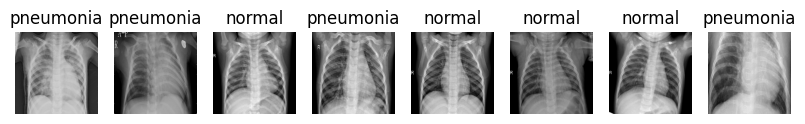

In [19]:
# Shuffle the dataset to mix normal and pneumonia images
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths, labels = zip(*combined)

# Show some sample images with their labels
def show_sample_images(image_paths, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    
    for i in range(num_samples):
        img = tf.keras.preprocessing.image.load_img(image_paths[i], target_size=IMAGE_SIZE)
        img = np.array(img)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')
    
    plt.show()
    
show_sample_images(image_paths, labels, num_samples=8)

The purpose of this function image_generator is to build a generator that produces sets of images along with labels for each image 
useful for training machine learning models 
efficient for loading and preprocessing of data.

In [20]:
# Function to create a data generator for images
def image_generator(image_paths, labels, batch_size):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_image_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            
            images = [tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE) for img_path in batch_image_paths]
            images = np.array([np.array(img) for img in images])
            
            # Convert labels to numerical format
            label_map = {'normal': 0, 'pneumonia': 1}
            batch_labels = np.array([label_map[label] for label in batch_labels])
            yield images, batch_labels

Splitting the dataset into training and validation

and creating Generators


In [21]:

train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create generators for training and validation
train_generator = image_generator(train_image_paths, train_labels, BATCH_SIZE)
val_generator = image_generator(val_image_paths, val_labels, BATCH_SIZE)


In [22]:
# Show the number of training and validation samples
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")


Number of training images: 6200
Number of validation images: 1550


In [24]:
# Step 5: Apply early stopping during training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


CNN Structure for classification 
adding droupouts for avoiding overfitting

In [25]:
# Model architecture (simple CNN for classification)
def build_classification_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification (normal/pneumonia)
    ])
    return model

In [30]:

# Build and compile the model
input_shape = (256, 256, 3)
model = build_classification_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, 
                    steps_per_epoch=len(train_image_paths)//BATCH_SIZE, 
                    validation_steps=len(val_image_paths)//BATCH_SIZE, epochs=20, callbacks=[early_stopping])

# Evaluate the model on both training and validation sets
final_train_loss, final_train_accuracy = model.evaluate(train_generator, steps=len(train_image_paths)//BATCH_SIZE)
final_val_loss, final_val_accuracy = model.evaluate(val_generator, steps=len(val_image_paths)//BATCH_SIZE)


Epoch 1/20
387/387 [==============================] - 142s 366ms/step - loss: 12.9150 - accuracy: 0.7647 - val_loss: 0.5160 - val_accuracy: 0.7624
Epoch 2/20
387/387 [==============================] - 128s 331ms/step - loss: 0.3967 - accuracy: 0.8452 - val_loss: 0.3755 - val_accuracy: 0.8763
Epoch 3/20
387/387 [==============================] - 126s 326ms/step - loss: 0.3304 - accuracy: 0.8651 - val_loss: 0.3273 - val_accuracy: 0.8906
Epoch 4/20
387/387 [==============================] - 130s 335ms/step - loss: 0.2806 - accuracy: 0.8963 - val_loss: 0.2536 - val_accuracy: 0.9238
Epoch 5/20
387/387 [==============================] - 130s 335ms/step - loss: 0.2149 - accuracy: 0.9271 - val_loss: 0.2399 - val_accuracy: 0.9375
Epoch 6/20
387/387 [==============================] - 125s 323ms/step - loss: 0.1580 - accuracy: 0.9445 - val_loss: 0.1508 - val_accuracy: 0.9518
Epoch 7/20
387/387 [==============================] - 126s 327ms/step - loss: 0.1229 - accuracy: 0.9597 - val_loss: 0.1381 

Final Training Loss: 0.025253402069211006
Final Training Accuracy: 0.995148777961731
Final Validation Loss: 0.06998462229967117
Final Validation Accuracy: 0.98046875


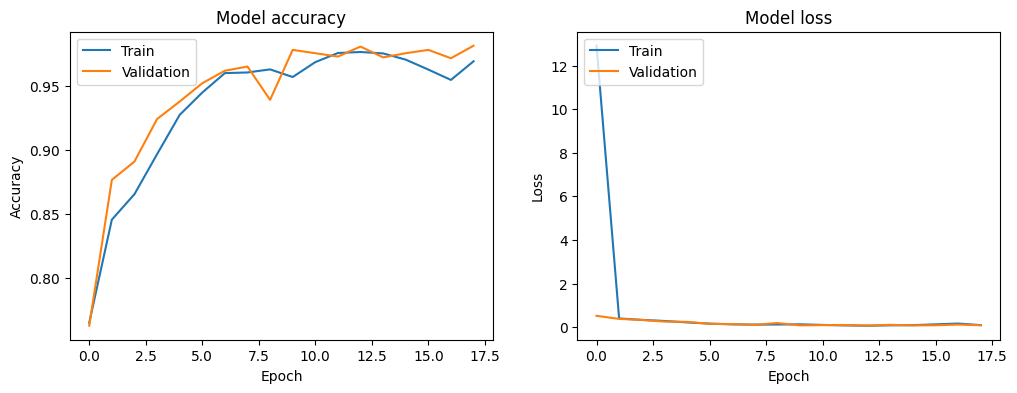

In [31]:
print(f"Final Training Loss: {final_train_loss}")
print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Loss: {final_val_loss}")
print(f"Final Validation Accuracy: {final_val_accuracy}")


# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

    
# Call the function to plot the training history
plot_training_history(history)

DATA SEGMENTATION

importing LIBRARIES

In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam

In [7]:
# Directories for images and masks
image_dir = r"D:\pneumonia\Kaggle_Pneumonia1\image"
mask_dir = r"D:\pneumonia\Kaggle_Pneumonia1\mask"

# Image size and batch size
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16


In [8]:
# Load image and mask paths
def load_image_mask_paths(base_image_dir, base_mask_dir):
    normal_image_dir = os.path.join(base_image_dir, 'normal')
    pneumonia_image_dir = os.path.join(base_image_dir, 'pneumonia')
    
    normal_mask_dir = os.path.join(base_mask_dir, 'normal')
    pneumonia_mask_dir = os.path.join(base_mask_dir, 'pneumonia')
    
    normal_image_paths = sorted([os.path.join(normal_image_dir, fname) for fname in os.listdir(normal_image_dir)])
    pneumonia_image_paths = sorted([os.path.join(pneumonia_image_dir, fname) for fname in os.listdir(pneumonia_image_dir)])
    
    normal_mask_paths = sorted([os.path.join(normal_mask_dir, fname) for fname in os.listdir(normal_mask_dir)])
    pneumonia_mask_paths = sorted([os.path.join(pneumonia_mask_dir, fname) for fname in os.listdir(pneumonia_mask_dir)])
    
    return normal_image_paths, pneumonia_image_paths, normal_mask_paths, pneumonia_mask_paths

# Load image and mask paths for normal and pneumonia
normal_image_paths, pneumonia_image_paths, normal_mask_paths, pneumonia_mask_paths = load_image_mask_paths(image_dir, mask_dir)

Upsample the Normal Images and Masks

In [9]:
# Show counts
print(f"Number of normal images: {len(normal_image_paths)}")
print(f"Number of pneumonia images: {len(pneumonia_image_paths)}")
print(f"Number of normal masks: {len(normal_mask_paths)}")
print(f"Number of pneumonia masks: {len(pneumonia_mask_paths)}")

Number of normal images: 1341
Number of pneumonia images: 3875
Number of normal masks: 1341
Number of pneumonia masks: 3875


In [10]:
# Step 3: Upsample normal images and masks
def upsample_images_and_masks(normal_image_paths, pneumonia_image_paths, normal_mask_paths, pneumonia_mask_paths):
    print(f"Before Upsampling - Normal: {len(normal_image_paths)}, Pneumonia: {len(pneumonia_image_paths)}")
    
    # Upsample normal images and masks
    normal_upsample_image = random.choices(normal_image_paths, k=len(pneumonia_image_paths))
    normal_upsample_mask = random.choices(normal_mask_paths, k=len(pneumonia_mask_paths))
    
    # Combine normal with pneumonia sets
    image_paths = normal_upsample_image + pneumonia_image_paths
    mask_paths = normal_upsample_mask + pneumonia_mask_paths
    labels = ['normal'] * len(normal_upsample_image) + ['pneumonia'] * len(pneumonia_image_paths)
    
    # Shuffle dataset
    combined = list(zip(image_paths, mask_paths, labels))
    random.shuffle(combined)
    
    image_paths, mask_paths, labels = zip(*combined)
    
    print(f"After Upsampling - Total images: {len(image_paths)}")
    
    return image_paths, mask_paths, labels

# Upsample normal images
image_paths, mask_paths, labels = upsample_images_and_masks(normal_image_paths, pneumonia_image_paths, normal_mask_paths, pneumonia_mask_paths)

Before Upsampling - Normal: 1341, Pneumonia: 3875
After Upsampling - Total images: 7750


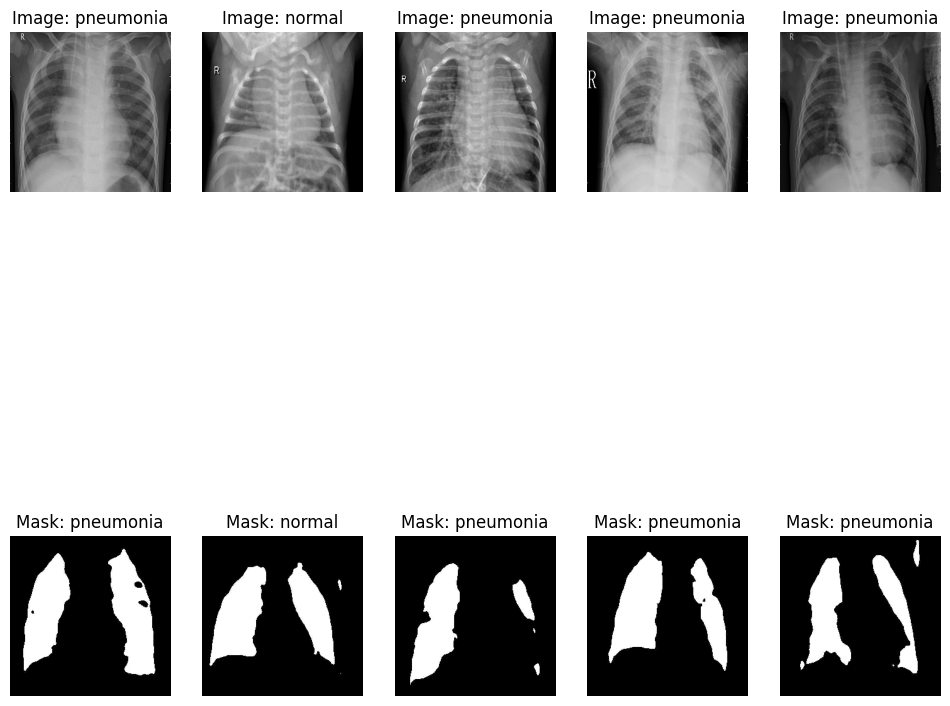

In [11]:
# Display sample images and masks
def show_sample_images_and_masks(image_paths, mask_paths, labels, num_samples=5):
    plt.figure(figsize=(12, 12))
    
    for i in range(num_samples):
        img = tf.keras.preprocessing.image.load_img(image_paths[i], target_size=IMAGE_SIZE)
        mask = tf.keras.preprocessing.image.load_img(mask_paths[i], target_size=IMAGE_SIZE, color_mode='grayscale')
        
        img = np.array(img)
        mask = np.array(mask)
        
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Image: {labels[i]}")
        plt.axis('off')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask: {labels[i]}")
        plt.axis('off')
    
    plt.show()

# Show sample images
show_sample_images_and_masks(image_paths, mask_paths, labels)

Display Sample Images and Masks

In [12]:
# Data augmentation for images and masks
def image_mask_generator(image_paths, mask_paths, batch_size):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_image_paths = image_paths[i:i+batch_size]
            batch_mask_paths = mask_paths[i:i+batch_size]
            
            images = [tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE) for img_path in batch_image_paths]
            masks = [tf.keras.preprocessing.image.load_img(mask_path, target_size=IMAGE_SIZE, color_mode='grayscale') for mask_path in batch_mask_paths]
            
            images = np.array([np.array(img) for img in images])
            masks = np.array([np.array(mask) for mask in masks])
            
            # Binarize the masks
            masks = (masks > 128).astype(np.float32)
            yield images, masks

# Split dataset into training and validation
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")

# Early stopping during training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
print("Early stopping applied with patience=5")

Number of training images: 6200
Number of validation images: 1550
Early stopping applied with patience=5


Data Augmentation for Images and Masks

Train/Test Split

Early Stopping Callback

USE THIS AFTER WARDS IT IS MAIN

In [39]:
# Build U-Net model with Dropout and Regularization
def build_unet(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder with dropout and L2 regularization
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(c1)
    c1 = tf.keras.layers.Dropout(0.3)(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(c2)
    c2 = tf.keras.layers.Dropout(0.3)(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(c3)
    c3 = tf.keras.layers.Dropout(0.4)(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(c4)
    c4 = tf.keras.layers.Dropout(0.4)(c4)
    
    # Decoder
    u1 = tf.keras.layers.UpSampling2D((2, 2))(c4)
    concat1 = tf.keras.layers.Concatenate()([u1, c3])
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(concat1)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(c5)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    
    u2 = tf.keras.layers.UpSampling2D((2, 2))(c5)
    concat2 = tf.keras.layers.Concatenate()([u2, c2])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(concat2)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(c6)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    
    u3 = tf.keras.layers.UpSampling2D((2, 2))(c6)
    concat3 = tf.keras.layers.Concatenate()([u3, c1])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(concat3)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(c7)
    c7 = tf.keras.layers.Dropout(0.3)(c7)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = tf.keras.models.Model(inputs, outputs)

    # Compile the model with a lower learning rate
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate and compile the U-Net model
unet_model = build_unet(input_shape=(256, 256, 3))
unet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d_3[0][0]']               
                                )                                                             

 Build U-Net Model

In [13]:

def build_unet(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    
    # Decoder
    u1 = tf.keras.layers.UpSampling2D((2, 2))(c4)
    concat1 = tf.keras.layers.Concatenate()([u1, c3])
    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    
    u2 = tf.keras.layers.UpSampling2D((2, 2))(c5)
    concat2 = tf.keras.layers.Concatenate()([u2, c2])
    c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    
    u3 = tf.keras.layers.UpSampling2D((2, 2))(c6)
    concat3 = tf.keras.layers.Concatenate()([u3, c1])
    c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat3)
    c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate and compile the U-Net model
unet_model = build_unet(input_shape=(256, 256, 3))
unet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [5]:
import gc

# Clear memory after each epoch
gc.collect()


0

In [14]:
# Training the model
train_gen = image_mask_generator(train_image_paths, train_mask_paths, BATCH_SIZE)
val_gen = image_mask_generator(val_image_paths, val_mask_paths, BATCH_SIZE)

steps_per_epoch = len(train_image_paths) // BATCH_SIZE
validation_steps = len(val_image_paths) // BATCH_SIZE

# 2. Callbacks: Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def lr_scheduler(epoch):
    return 1e-4 * 10**(-epoch / 20)

lr_schedule = LearningRateScheduler(lr_scheduler)

history = unet_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


: 

In [12]:
#Plot training and validation accuracy/loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

# Plot the training history
plot_training_history(history)


Epoch 1/50
387/387 [==============================] - 5781s 15s/step - loss: 2.8772 - accuracy: 0.8133 - val_loss: 2.8242 - val_accuracy: 0.8169
Epoch 2/50
387/387 [==============================] - 5767s 15s/step - loss: 2.8798 - accuracy: 0.8133 - val_loss: 2.8242 - val_accuracy: 0.8169
Epoch 3/50
387/387 [==============================] - 5752s 15s/step - loss: 2.8800 - accuracy: 0.8133 - val_loss: 2.8242 - val_accuracy: 0.8169
Epoch 4/50
387/387 [==============================] - 5770s 15s/step - loss: 2.8798 - accuracy: 0.8133 - val_loss: 2.8242 - val_accuracy: 0.8169
Epoch 5/50
387/387 [==============================] - 5815s 15s/step - loss: 2.8794 - accuracy: 0.8133 - val_loss: 2.8242 - val_accuracy: 0.8169
Epoch 6/50
  1/387 [..............................] - ETA: 1:32:39 - loss: 2.9481 - accuracy: 0.8089

KeyboardInterrupt: 